In [1]:
import warnings
warnings.simplefilter("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import sklearn.datasets
#import sklearn.feature_extraction.text
#import sklearn.preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
import scipy.sparse
import vectorizers
import vectorizers.transformers
import seaborn as sns
import igraph as ig
from scipy.sparse import vstack
sns.set()
import umap
import umap.plot
umap.plot.output_notebook()
from bokeh.plotting import show
from collections import Counter

import sklearn.model_selection
import sklearn.ensemble
import sklearn.linear_model
import sklearn.neural_network
import sklearn.neighbors


Loading BokehJS ...

# NCI Datasets

We build one large graph from 4000+ smaller ones (there are 2 datasets, NCI1 and NCI109)
For each vertex, we have the following attributes:
* name:  unique for each vertex (1-based str)
* graph: the small graph this node belongs to (1-based int)
* label: the vertex label (1-based int)

Note that some vertices have label and are assigned to a small graph, but are not part of any edge.
We add those as isolated vertices nevertheless.

Each small graph belongs to one of two classes; the classes are roughly balanced.


In [2]:
datadir = '../Data/NCI1/'

## read data from NCI folder
fn_edges = datadir+'DS_A.txt'
fn_graph_id = datadir+'DS_graph_indicator.txt'
fn_graph_label = datadir+'DS_graph_labels.txt'
fn_node_label = datadir+'DS_node_labels.txt'


In [3]:
## read edges, build overall graph
with open(fn_edges) as f:
    E = [tuple(map(int,x.strip().split(','))) for x in f.readlines()]
G = ig.Graph.TupleList(E, directed=True).as_undirected()

## read subgraph node memberships (subgraphs names are 1-based)
with open(fn_graph_id) as f:
    sg_mem = [int(x.strip())-1 for x in f.readlines()]
    
## some vertices do not appear in any edges
## we add those as isolated nodes for easier processing.
vertices = set(G.vs['name'])
print('number of vertices before:',G.vcount(),'min index:',min(vertices),'max index:',max(vertices))
v = set(np.arange(1,len(sg_mem)+1))
diff = v.difference(vertices)
G.add_vertices(list(diff))
print('number of vertices afteur:',G.vcount(),'min index:',min(vertices),'max index:',max(vertices))

## mapping nodes in order of name
node_idx = list(np.argsort(G.vs['name']))

## assign subgraph
for i in range(len(sg_mem)):
    G.vs[node_idx[i]]['graph'] = sg_mem[i]

## verify with graph label list -- should output 'True'
l = [G.vs[i]['graph'] for i in node_idx]
if l != sg_mem:
    print('something is wrong')

## read and store node labels
with open(fn_node_label) as f:
    l = [int(x.strip()) for x in f.readlines()]
for i in range(len(l)):
    G.vs[node_idx[i]]['label'] = l[i]

## read graph labels
with open(fn_graph_label) as f:
    graph_labels = [int(x.strip()) for x in f.readlines()]
    

number of vertices before: 122319 min index: 1 max index: 122747
number of vertices afteur: 122747 min index: 1 max index: 122747


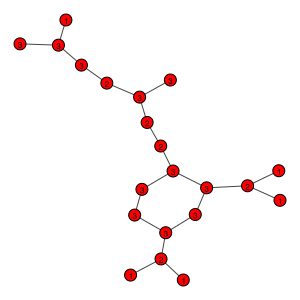

In [4]:
## subgraphs are easy to get
sg_no = 0
sg = G.subgraph(np.where(np.array(G.vs['graph']) == sg_no)[0].tolist())
ig.plot(sg, bbox=(300,300), vertex_size=12, vertex_label_size=8)

## Method 2 - walks

Very simple random fixed length random walks, for comparison only.

We can either include the node labels or not (default = include).


In [5]:
## number ond length of walks per graph
walk_len = 30
walk_nbr = 100

## else, use only the degrees
use_node_labels = True


In [6]:
## Build walks
L1 = []
for i in range(max(G.vs['graph'])+1):
    L2 = []
    sg = G.subgraph(np.where(np.array(G.vs['graph']) == i)[0].tolist())
    Deg = sg.degree()
    Lab = sg.vs['label']
    n = sg.vcount()
    ctr = 0
    while ctr<walk_nbr:
        marche = sg.random_walk(start=np.random.choice(n), steps=walk_len-1)
        if len(marche)==walk_len:
            if use_node_labels:
                v = [str(Deg[k])+'_'+str(Lab[k]) for k in marche]
            else:
                v = [str(Deg[k]) for k in marche]
            L2.append(np.array(v))
            ctr += 1
    L2 = np.array(L2)
    L1.append(L2)
L = np.array(L1, dtype=object)


In [7]:
walks = np.vstack(L)
walks.shape

(411000, 30)

In [8]:
%%time
word_vectorizer = vectorizers.TokenCooccurrenceVectorizer(
    min_document_occurrences=5,
    window_radii=(1,5),
    window_functions=("fixed", "variable"),
    kernel_functions=("geometric", "geometric"),
    kernel_args=({}, {"offset":1}),
    #mask_string="[##MASK##]",
    #nullify_mask=True,
    n_iter=2,
    normalize_windows=True,
    n_threads=32
).fit(walks)
word_vectors = word_vectorizer.transform(walks)


CPU times: user 12min 16s, sys: 1.92 s, total: 12min 18s
Wall time: 2min 8s


In [9]:
%%time
ngrammer = vectorizers.NgramVectorizer(
    token_dictionary=word_vectorizer.token_label_dictionary_
)
doc_matrix = ngrammer.fit_transform(walks)

CPU times: user 39 s, sys: 698 ms, total: 39.7 s
Wall time: 39.8 s


In [10]:
n_g = max(G.vs['graph'])+1
n_g

4110

In [11]:
%%time
Inc = np.array(np.arange(0,n_g*walk_nbr)).reshape((n_g,walk_nbr))
inc_matrix = vectorizers.NgramVectorizer(
).fit_transform(Inc)


CPU times: user 1.45 s, sys: 37.5 ms, total: 1.49 s
Wall time: 1.49 s


In [12]:
awe_matrix = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    random_state=42,
).fit_transform(inc_matrix, vectors=doc_matrix)

In [13]:
doc_matrix_norm = normalize(doc_matrix, axis=1, norm='l1')
awe_matrix_norm = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    random_state=42,
).fit_transform(inc_matrix, vectors=doc_matrix_norm)

In [14]:
import pickle
with open('Results/walks_NCI1.pkl','wb') as fp:
    pickle.dump( (awe_matrix,awe_matrix_norm), fp)
